In [112]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import scanpy as sc
import pickle

import scipy.ndimage as ndi
import skimage.morphology as morph
import cv2
import colorcet as cc
from matplotlib.colors import to_hex
from scipy.stats import spearmanr
from scipy.stats import linregress
from scipy.stats import hypergeom
import scipy.ndimage as ndi
from scipy.signal import fftconvolve
from heatmap2 import heatmap2
from PIL import Image

import glob
import os
from scipy import spatial

import tqdm.auto as tqdm
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression
from itertools import combinations
from matplotlib.colors import ListedColormap
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
import warnings
plt.rcParams['svg.fonttype']='none'

In [113]:
adata = sc.read_h5ad('/common/ingn/pembroRT-immune/codex/TNBC_immune_processed_v6_clean.h5ad')
dist_tissue = pd.read_csv('/common/mebaner/data/CODEX_district_pct_tissue.csv', index_col=0)
ct_tissue = pd.read_csv('/common/mebaner/data/CODEX_celltype_pct_tissue.csv', index_col=0)
tissue_area = pd.read_csv('/common/mebaner/immune/tissue_area.csv')
df = adata.obs
coords = adata.obsm['coordinates']
x = coords.T[0]
y = coords.T[1]
df['x'] = x
df['y'] = y

In [114]:
data_dir = '/common/mebaner/data/immune/'
response = pd.read_csv(data_dir + 'Supplementary_Table_CODEX_response_groups.csv', index_col=0)

In [120]:
# compute counts within each radius in rs of points in d2 around points in d1
# used for the calculation of the spatial cross correlation coefficient

def cf(d1, d2, rs):
    distances = spatial.distance.cdist(d1, d2, 'euclidean')
    res = {}
    for r in rs:
        res[r] = np.count_nonzero(distances < r, axis=1)
    out = []
    for r in rs:
        out.append(np.sum(res[r]) / len(d1))
    return out

In [122]:
# compute all counts for each district pair
# this can take a while, so compute once and then just read in from a file

# start = 10
# end = 3000
# N = 50
# rs = np.logspace(np.log10(start), np.log10(end), N)

# pairs = []
# for i in range(0,12):
#     for j in range(0,12):
#         pairs.append((i,j))
        
# bs = adata.obs.biopsy_2.unique()

# counts = pd.DataFrame()

# d1col = []
# d2col = []
# corr_col = []
# b_col = []
# r_col = []
# rlist = list(rs)
# for b in bs:
#     a = df.loc[df['biopsy_2'] == b]
#     for p in pairs:
#         d1 = a.loc[(a['district'] == p[0])]
#         d2 = a.loc[(a['district'] == p[1])]
#         d1coords = np.column_stack((d1.x.values, d1.y.values))
#         d2coords = np.column_stack((d2.x.values, d2.y.values))
#         corr = cf(d1coords, d2coords, rs)
#         b_col = b_col + list(np.full(N, b))
#         d1col = d1col + list(np.full(N, p[0]))
#         d2col = d2col + list(np.full(N, p[1]))
#         corr_col = corr_col + corr
#         r_col = r_col + rlist

# counts['district_a'] = d1col
# counts['district_b'] = d2col
# counts['counts'] = corr_col
# counts['biopsy_2'] = b_col
# counts['r'] = r_col
# counts

In [123]:
# read in counts from file
out = pd.read_csv('/common/mebaner/immune/data/district_counts.csv', index_col=0)

In [124]:
out

,district_a,district_b,counts,biopsy_2,r
0,0,0,1.007192,h09_1_210113,10.000000
1,0,0,1.016985,h09_1_210113,11.234493
2,0,0,1.037490,h09_1_210113,12.621384
3,0,0,1.083703,h09_1_210113,14.179486
4,0,0,1.169855,h09_1_210113,15.929934
...,...,...,...,...,...
547195,11,11,1192.433803,h43_2_210909,1883.246959
547196,11,11,1314.270257,h43_2_210909,2115.732560
547197,11,11,1455.648384,h43_2_210909,2376.918357
547198,11,11,1620.115162,h43_2_210909,2670.347369


In [125]:
treatment = []
responder = []
response_group = []
patient = []
for b in out.biopsy_2:
    if(b.split('_')[1] == '1'):
        treatment.append('Baseline')
    elif(b.split('_')[1] == '2'):
        treatment.append('PD1')
    elif(b.split('_')[1] == '3'):
        treatment.append('RTPD1')
    else:
        print(b)
    responder.append(response.loc[b.split('_')[0]]['responder'])
    response_group.append(response.loc[b.split('_')[0]]['response_group'])
    patient.append(b.split('_')[0])
out['treatment'] = treatment
out['responder'] = responder
out['response_group'] = response_group
out['patient'] = patient

In [126]:
out

,district_a,district_b,counts,biopsy_2,r,treatment,responder,response_group,patient
0,0,0,1.007192,h09_1_210113,10.000000,Baseline,R,R1,h09
1,0,0,1.016985,h09_1_210113,11.234493,Baseline,R,R1,h09
2,0,0,1.037490,h09_1_210113,12.621384,Baseline,R,R1,h09
3,0,0,1.083703,h09_1_210113,14.179486,Baseline,R,R1,h09
4,0,0,1.169855,h09_1_210113,15.929934,Baseline,R,R1,h09
...,...,...,...,...,...,...,...,...,...
547195,11,11,1192.433803,h43_2_210909,1883.246959,PD1,R,R1,h43
547196,11,11,1314.270257,h43_2_210909,2115.732560,PD1,R,R1,h43
547197,11,11,1455.648384,h43_2_210909,2376.918357,PD1,R,R1,h43
547198,11,11,1620.115162,h43_2_210909,2670.347369,PD1,R,R1,h43


In [127]:
tissue_area

,Unnamed: 0,path,tissue_path,cassette_region,cassette,region,downsampled_5x_total_px,downsampled_5x_area
0,0,/media/nathan-backup/cerberus/common/CODEX_PRO...,/media/nathan-backup/cerberus/common/CODEX_PRO...,210113_Breast_Cassette11_reg1,210113_Breast_Cassette11,reg1,21307392,7916100
1,1,/media/nathan-backup/cerberus/common/CODEX_PRO...,/media/nathan-backup/cerberus/common/CODEX_PRO...,210113_Breast_Cassette11_reg2,210113_Breast_Cassette11,reg2,60016355,15598330
2,2,/media/nathan-backup/cerberus/common/CODEX_PRO...,/media/nathan-backup/cerberus/common/CODEX_PRO...,210115_Breast_Cassette15_reg1,210115_Breast_Cassette15,reg1,12518993,5408909
3,3,/media/nathan-backup/cerberus/common/CODEX_PRO...,NaN,210115_Breast_Cassette15_reg2,210115_Breast_Cassette15,reg2,49088856,15411055
4,4,/media/nathan-backup/cerberus/common/CODEX_PRO...,/media/nathan-backup/cerberus/common/CODEX_PRO...,210118_Breast_Cassette14_reg1,210118_Breast_Cassette14,reg1,8940100,3977903
...,...,...,...,...,...,...,...,...
106,106,/media/nathan-backup/cerberus/common/CODEX_PRO...,/media/nathan-backup/cerberus/common/CODEX_PRO...,210907_PembroRT_Cas14_TLSpanel_reg4,210907_PembroRT_Cas14_TLSpanel,reg4,16777216,5930882
107,107,/media/nathan-backup/cerberus/common/CODEX_PRO...,/media/nathan-backup/cerberus/common/CODEX_PRO...,210908_PembroRT_Cas15_TLSpanel_reg1,210908_PembroRT_Cas15_TLSpanel,reg1,9772194,4900128
108,108,/media/nathan-backup/cerberus/common/CODEX_PRO...,/media/nathan-backup/cerberus/common/CODEX_PRO...,210908_PembroRT_Cas15_TLSpanel_reg2,210908_PembroRT_Cas15_TLSpanel,reg2,49506160,14675799
109,109,/media/nathan-backup/cerberus/common/CODEX_PRO...,/media/nathan-backup/cerberus/common/CODEX_PRO...,210909_PembroRT_Cas21_TLSpanel_reg1,210909_PembroRT_Cas21_TLSpanel,reg1,5907366,2805105


In [128]:
cd = {}
for c in tissue_area.cassette_region.unique():
    dfs = df.loc[df['sample_id'] == c + '_v5']
    if(len(dfs) > 0):
        cd[c] = dfs.biopsy_2.unique()[0]
    if(len(dfs.biopsy_2.unique()) > 1):
        print(c)
        
bd = {v: k for k, v in cd.items()}
bd['h05_3_210201'] = '210201_Breast_Cassette1_reg2'
bd['h04_3_210205'] = '210205_Breast_Cassette2_reg1'
bd['h12_1_210205'] = '210205_Breast_Cassette2_reg2'

210201_Breast_Cassette1_reg1
210205_Breast_Cassette2_reg1


In [129]:
c = '210205_Breast_Cassette2_reg1'

In [130]:
# compute surface densities in cells/pixel for each district

den_d = {}
b2s = df.biopsy_2.unique()
for d in np.arange(0,12):
    den_d[d] = {}
    for b in b2s:
        Ncells = len(df.loc[(df['biopsy_2'] == b) & (df['district'] == d)])
        area = tissue_area.loc[tissue_area['cassette_region'] == bd[b]]['downsampled_5x_area'].values[0] * 25
        den_d[d][b] = Ncells/area

In [131]:
# compute spatial cross correlation coefficient from counts and densities

cf = []
for d2, c, b, r in zip(out.district_b.values, out.counts.values, out.biopsy_2.values, out.r.values):
    den = den_d[d2][b]
    expected = den * np.pi * r**2
    xi = c / expected - 1
    cf.append(xi)
out['cf'] = cf

In [132]:
palette = sns.color_palette(cc.glasbey, n_colors=12)
cmap = {}
for i in np.arange(0, 12):
    cmap[i] = palette[i]

In [133]:
rs = out.r.unique()

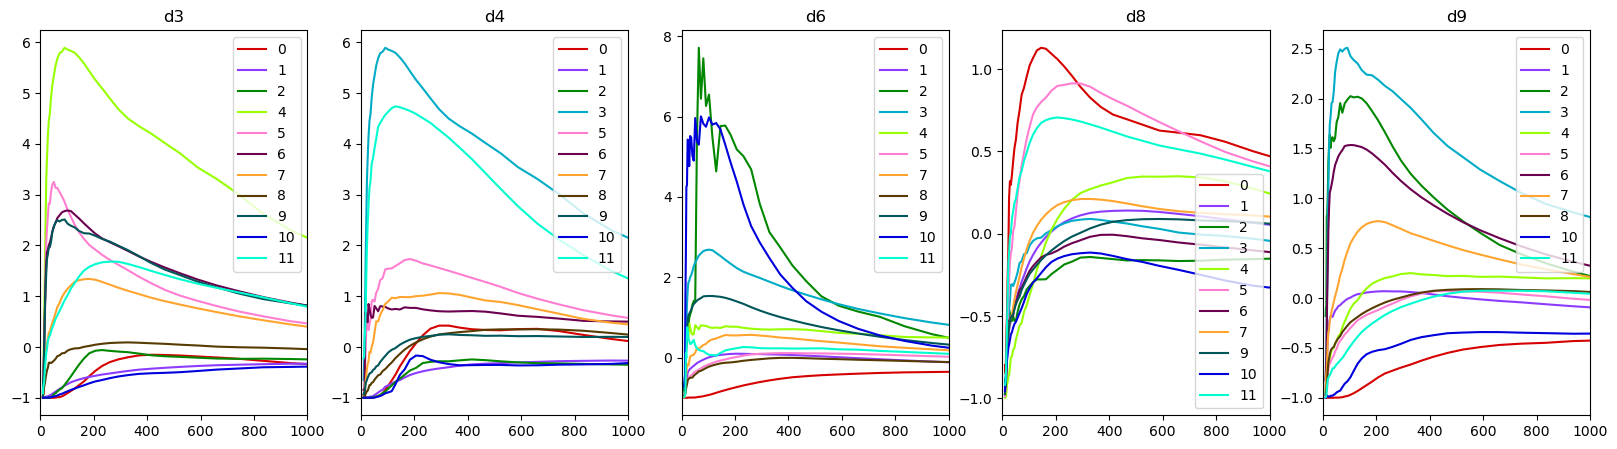

In [134]:
f, axs = plt.subplots(ncols=5, nrows=1, figsize=(20,5))
for k, d in enumerate([3,4, 6,8,9]):
    for i in np.arange(0,12):
        if(i != d):
            test = out.loc[(out['district_a'] == d) & (out['district_b'] == i) & (out['treatment'] == 'Baseline') & (out['response_group'] == 'R2')]
            cfs = []
            for r in rs:
                test_r = test.loc[test['r'] == r]
                cfs.append(test_r.cf.mean())
            ax=axs[k]
            ax.plot(rs, cfs, label=i, color=cmap[i])
            #ax.set_ylim(-1,4)
            ax.set_xlim(0,1000)
            ax.set_title('d' +str(d))
            ax.legend()
            #ax.axvline(rs[21], color='black', lw=2)
#plt.savefig('/common/mebaner/immune/corr_all.svg', format='svg', bbox_inches='tight')

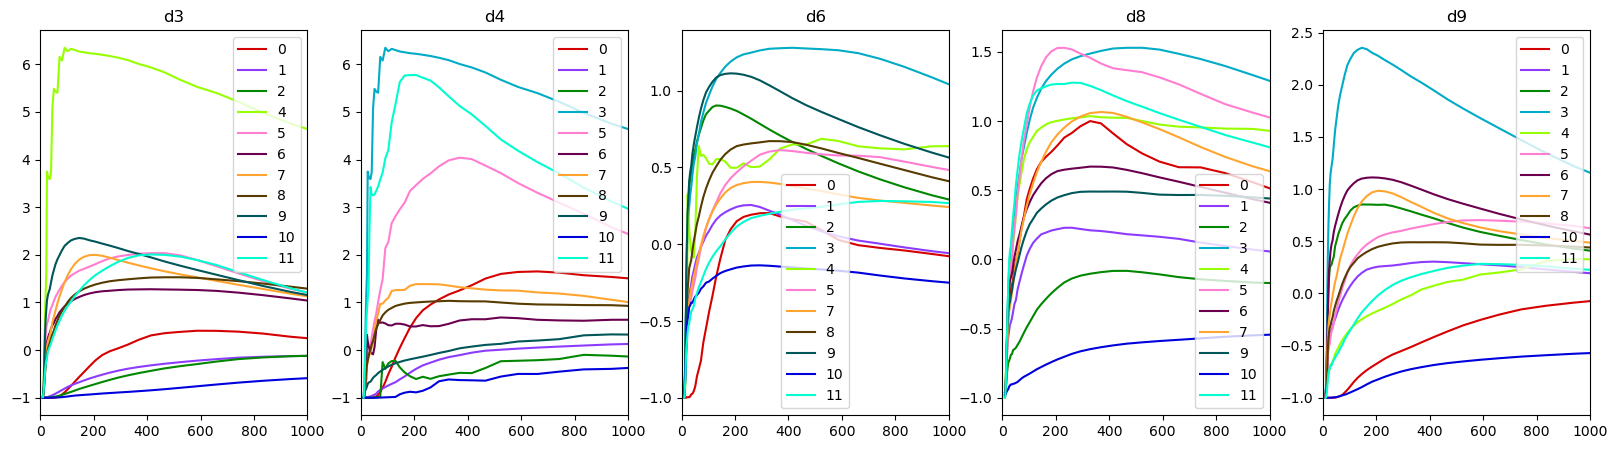

In [26]:
f, axs = plt.subplots(ncols=5, nrows=1, figsize=(20,5))
for k, d in enumerate([3,4, 6,8,9]):
    for i in np.arange(0,12):
        if(i != d):
            test = out.loc[(out['district_a'] == d) & (out['district_b'] == i) & (out['treatment'] == 'PD1') & (out['response_group'] == 'NR')]
            cfs = []
            for r in rs:
                test_r = test.loc[test['r'] == r]
                cfs.append(test_r.cf.mean())
            ax=axs[k]
            ax.plot(rs, cfs, label=i, color=cmap[i])
            #ax.set_ylim(-1,4)
            ax.set_xlim(0,1000)
            ax.set_title('d' +str(d))
            ax.legend()
            #ax.axvline(rs[21], color='black', lw=2)
#plt.savefig('/common/mebaner/immune/corr_all.svg', format='svg', bbox_inches='tight')

In [27]:
sub = out.loc[(out['district_a'] == 3) & (out['district_b'] == 4) & (out['r'] == rs[21])].dropna()
sub

,district_a,district_b,counts,biopsy_2,r,treatment,responder,response_group,patient,cf
2021,3,4,2.647273,h09_1_210113,115.245346,Baseline,R,R1,h09,5.191351
9221,3,4,11.683736,h02_1_210115,115.245346,Baseline,R,R1,h02,2.736035
23621,3,4,4.523884,h02_3_210118,115.245346,RTPD1,R,R1,h02,9.539742
30821,3,4,5.115877,h10_2_210122,115.245346,PD1,NR,NR,h10,8.614099
38021,3,4,0.080000,h17_3_210125,115.245346,RTPD1,NR,NR,h17,61.727528
...,...,...,...,...,...,...,...,...,...,...
513221,3,4,8.806636,h15_2_210827,115.245346,PD1,NR,NR,h15,6.193959
520421,3,4,3.206557,h02_3_210907,115.245346,RTPD1,R,R1,h02,4.907032
527621,3,4,12.238370,h02_1_210908,115.245346,Baseline,R,R1,h02,2.819647
534821,3,4,14.342380,h47_3_210909,115.245346,RTPD1,R,R2,h47,2.728018


<AxesSubplot:xlabel='treatment', ylabel='cf'>

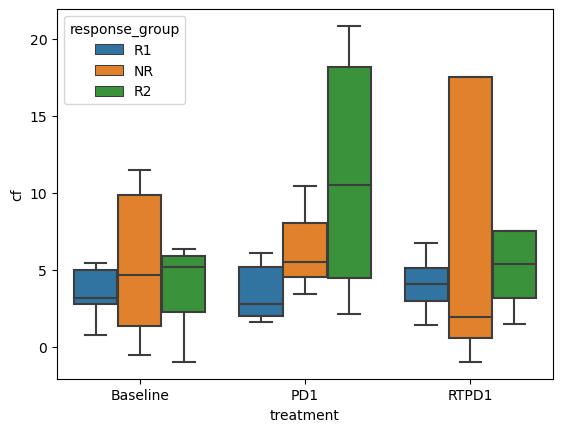

In [28]:
# box plots for district pair in sub
sns.boxplot(data=sub, x='treatment', y='cf', hue='response_group', showfliers=False, order=['Baseline', 'PD1', 'RTPD1'])

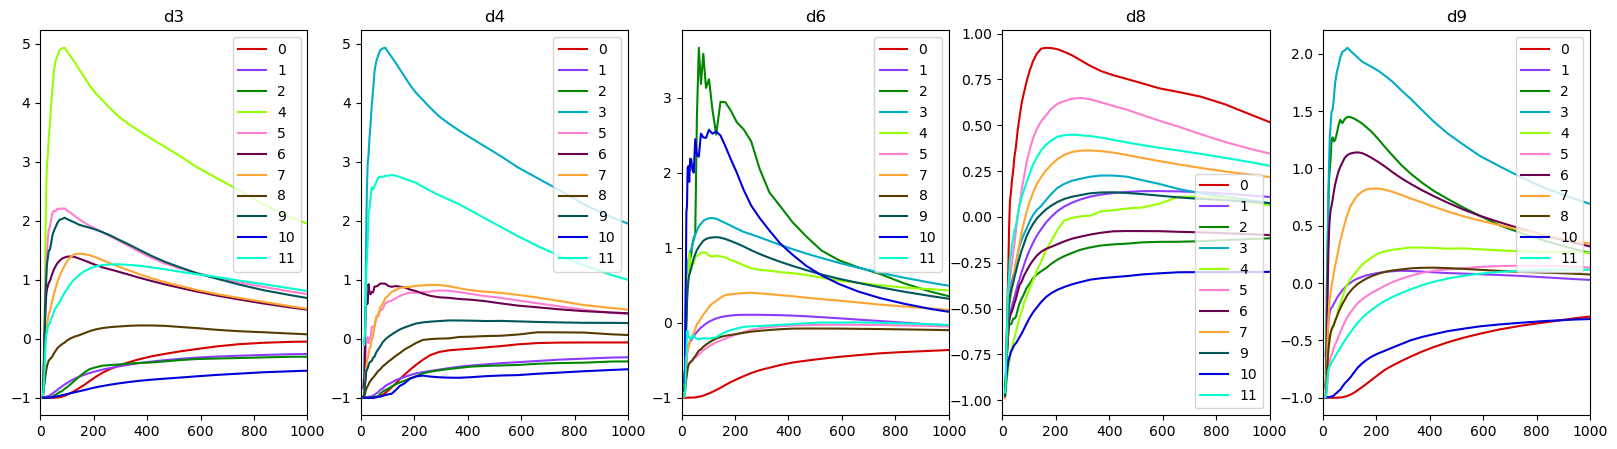

In [31]:
f, axs = plt.subplots(ncols=5, nrows=1, figsize=(20,5))
for k, d in enumerate([3,4, 6,8,9]):
    for i in np.arange(0,12):
        if(i != d):
            test = out.loc[(out['district_a'] == d) & (out['district_b'] == i) & (out['treatment'] == 'Baseline')]
            cfs = []
            for r in rs:
                test_r = test.loc[test['r'] == r]
                cfs.append(test_r.cf.mean())
            ax=axs[k]
            ax.plot(rs, cfs, label=i, color=cmap[i])
            #ax.set_ylim(-1,4)
            ax.set_xlim(0,1000)
            ax.set_title('d' +str(d))
            ax.legend()
            #ax.axvline(rs[21], color='black', lw=2)
# plt.savefig('/common/mebaner/immune/corr_all.svg', format='svg', bbox_inches='tight')

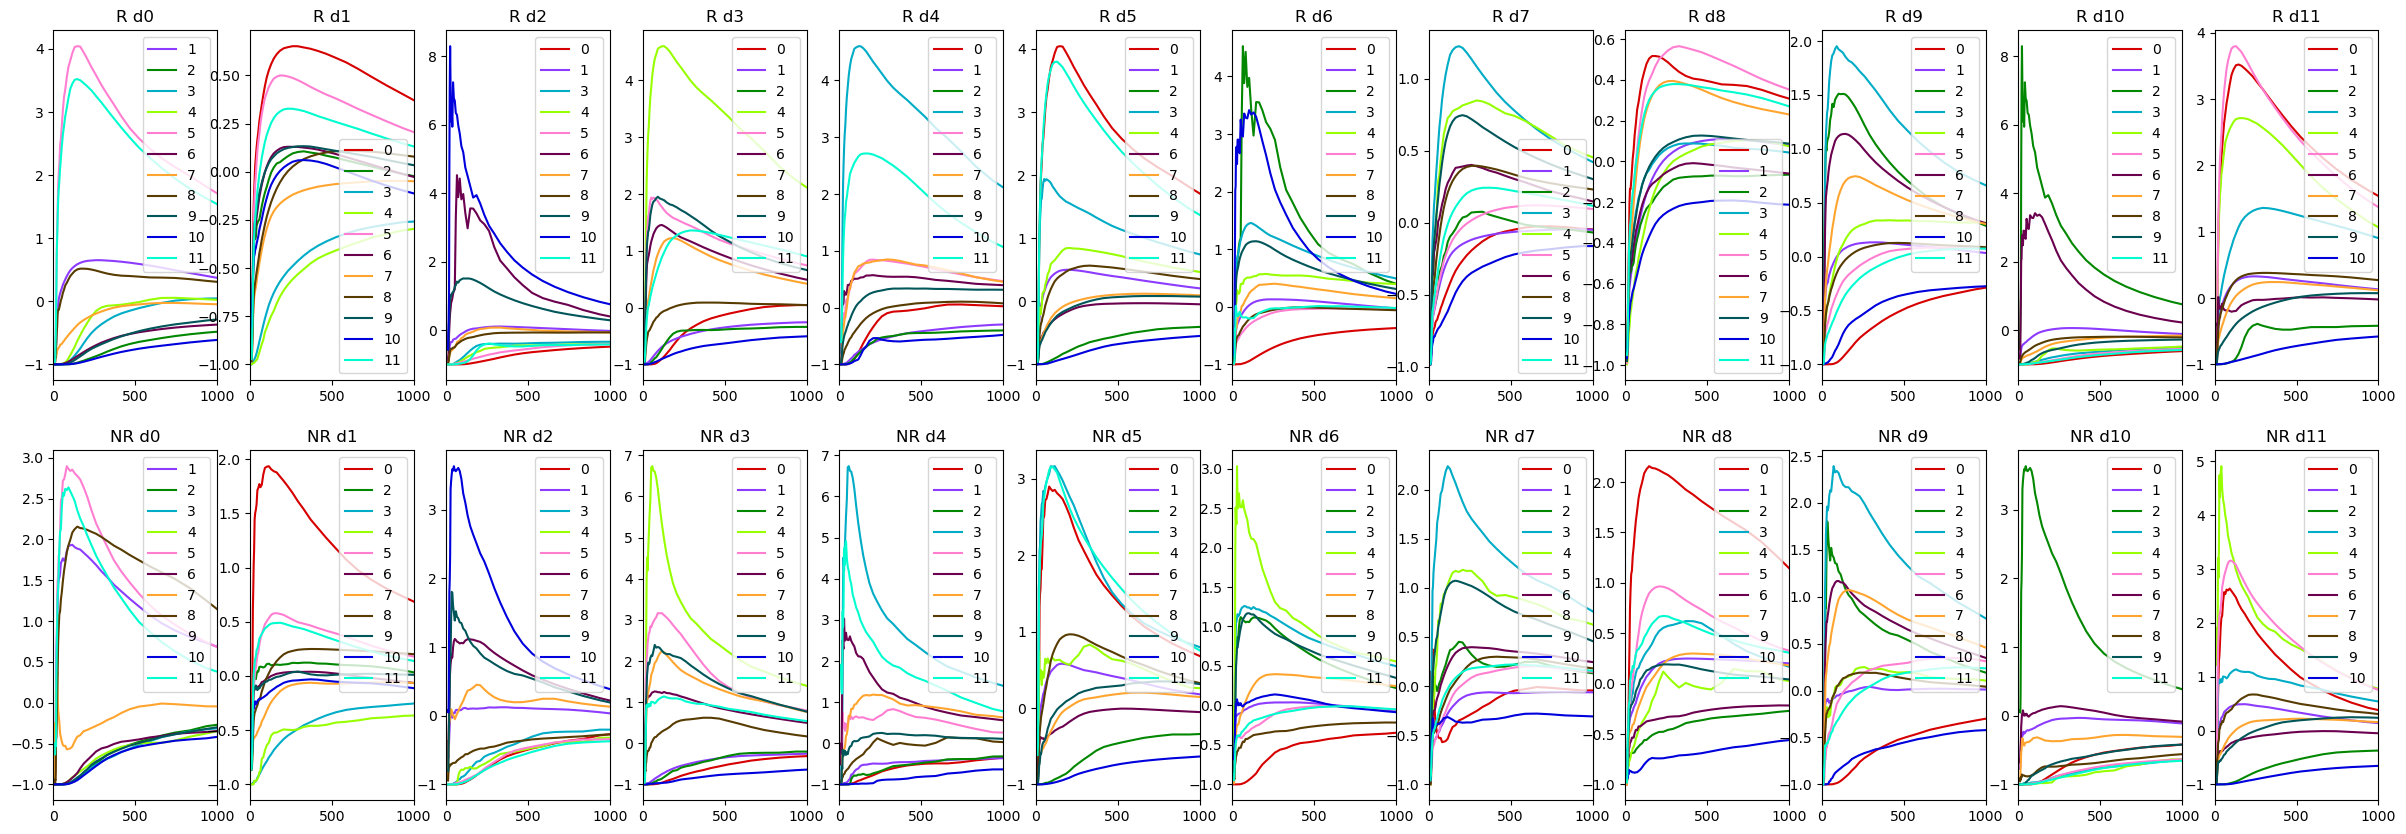

In [32]:
f, axs = plt.subplots(ncols=12, nrows=2, figsize=(30,10))
for k, d in enumerate(np.arange(0,12)):
#for k, d in enumerate([3,4, 6,8,9]):
    for j,R in enumerate(['R', 'NR']):
        for i in np.arange(0,12):
            if(i != d):
                if((len(R)==1) | (R=='NR')):
                    test = out.loc[(out['district_a'] == d) & (out['district_b'] == i) & (out['treatment'] == 'Baseline') & (out['responder'] == R)]
                else:
                    test = out.loc[(out['district_a'] == d) & (out['district_b'] == i) & (out['treatment'] == 'Baseline') & (out['response_group'] == R)]
                cfs = []
                for r in rs:
                    test_r = test.loc[test['r'] == r]
                    cfs.append(test_r.cf.mean())
                ax=axs[j][k]
                ax.plot(rs, cfs, label=i, color=cmap[i])
                #ax.set_ylim(-1,4)
                ax.set_xlim(0,1000)
                ax.set_title(R + ' d' +str(d))
                ax.legend()
                #ax.axvline(rs[21], color='black', lw=2)
# plt.savefig('/common/mebaner/immune/corr.svg', format='svg', bbox_inches='tight')